In [1]:
import numpy as np

# Define the model mapping
groq_models = {
    "llama3-70b": "llama3-70b-8192",
    "mixtral": "mixtral-8x7b-32768",
    "gemma-7b": "gemma-7b-it",
    "llama3.1-70b": "llama-3.1-70b-versatile",
    "llama3-8b": "llama3-8b-8192",
    "llama3.1-8b": "llama-3.1-8b-instant",""
    "gemma-9b": "gemma2-9b-it"
}

activity_labels = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}
reverse_activity_labels = {v: k for k, v in activity_labels.items()}

print("Activity Labels Dictionary: ", reverse_activity_labels)


Activity Labels Dictionary:  {'WALKING': 1, 'WALKING_UPSTAIRS': 2, 'WALKING_DOWNSTAIRS': 3, 'SITTING': 4, 'STANDING': 5, 'LAYING': 6}


In [2]:
combined_dataset_x = np.load('../Data/combined_dataset.npy')
print(f"Loaded dataset shape: {combined_dataset_x.shape}")

combined_dataset_y= np.array([1,2,3,4,5,6]*4)
print(f"X_test_real_reshaped shape: {combined_dataset_x.shape}")
print(f"y_test_reshaped shape: {combined_dataset_y.shape}")

Loaded dataset shape: (24, 500, 3)
X_test_real_reshaped shape: (24, 500, 3)
y_test_reshaped shape: (24,)


In [3]:

X_test = combined_dataset_x[:,:,:]
y_test = combined_dataset_y[:]

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (24, 500, 3)
y_test shape: (24,)


In [4]:
import json
import pickle

with open('variable.json', 'r') as f:
    data = json.load(f)
columns = data['my_variable']
print(len(columns))  # Output: Hello, World!

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('PCA.pkl', 'rb') as f:
    pca = pickle.load(f)

with open('dt2_model.sav', 'rb') as f:
    dt2 = pickle.load(f)

print(type(pca))
print(type(scaler))
print(type(dt2))

print(columns)

803
<class 'sklearn.decomposition._pca.PCA'>
<class 'sklearn.preprocessing._data.StandardScaler'>
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
['0_Absolute energy', '0_Autocorrelation', '0_Centroid', '0_ECDF Percentile_0', '0_Entropy', '0_FFT mean coefficient_0', '0_FFT mean coefficient_1', '0_FFT mean coefficient_10', '0_FFT mean coefficient_100', '0_FFT mean coefficient_101', '0_FFT mean coefficient_102', '0_FFT mean coefficient_103', '0_FFT mean coefficient_104', '0_FFT mean coefficient_105', '0_FFT mean coefficient_106', '0_FFT mean coefficient_107', '0_FFT mean coefficient_108', '0_FFT mean coefficient_109', '0_FFT mean coefficient_11', '0_FFT mean coefficient_110', '0_FFT mean coefficient_111', '0_FFT mean coefficient_112', '0_FFT mean coefficient_113', '0_FFT mean coefficient_114', '0_FFT mean coefficient_115', '0_FFT mean coefficient_116', '0_FFT mean coefficient_117', '0_FFT mean coefficient_118', '0_FFT mean coefficient_119', '0_FFT mean coefficient_12', '0_FFT mean

In [5]:

import tsfel
import numpy as np
import pandas as pd

# Extract features using TSFEL
cfg = tsfel.get_features_by_domain()  # Get all features by default
X_test_tsfel = tsfel.time_series_features_extractor(cfg, X_test, verbose=1, fs=50)

# Convert to DataFrame to retain column names
X_test_tsfel_df = pd.DataFrame(X_test_tsfel)
print(X_test_tsfel_df.columns)
X_test_normalized_columns = columns
# Find the intersection
matching_columns = [col for col in columns if col in X_test_tsfel_df.columns]
print("Matching columns in X_test_real_tsfel:")
print(matching_columns)
# Filter X_test_real_tsfel_df to include only the matching columns
X_test_real_tsfel_filtered_df = X_test_tsfel_df[matching_columns]
print("Shape of filtered X_test_real_tsfel:")
print(X_test_real_tsfel_filtered_df.shape)

*** Feature extraction started ***



*** Feature extraction finished ***
Index(['0_Absolute energy', '0_Area under the curve', '0_Autocorrelation',
       '0_Average power', '0_Centroid', '0_ECDF Percentile Count_0',
       '0_ECDF Percentile Count_1', '0_ECDF Percentile_0',
       '0_ECDF Percentile_1', '0_ECDF_0',
       ...
       '2_Wavelet variance_0', '2_Wavelet variance_1', '2_Wavelet variance_2',
       '2_Wavelet variance_3', '2_Wavelet variance_4', '2_Wavelet variance_5',
       '2_Wavelet variance_6', '2_Wavelet variance_7', '2_Wavelet variance_8',
       '2_Zero crossing rate'],
      dtype='object', length=1152)
Matching columns in X_test_real_tsfel:
['0_Absolute energy', '0_Autocorrelation', '0_Centroid', '0_ECDF Percentile_0', '0_Entropy', '0_FFT mean coefficient_0', '0_FFT mean coefficient_1', '0_FFT mean coefficient_10', '0_FFT mean coefficient_100', '0_FFT mean coefficient_101', '0_FFT mean coefficient_102', '0_FFT mean coefficient_103', '0_FFT mean coefficient_104', '0_FFT mean coefficient_105', '0_FFT

In [6]:

X_test_real_tsfel = X_test_real_tsfel_filtered_df.to_numpy()
X_test_normalized_real = scaler.transform(X_test_real_tsfel)
# Apply PCA
X_test_pca_20 = pca.transform(X_test_normalized_real)
print("X_test_pca shape: ", X_test_pca_20.shape)


with open('../Task3/X_train_pca_20.json', 'r') as f:
    data = json.load(f)
    X_train_pca_20 = np.array(data['X_train_pca_20'])

# Load the y_train data
with open('../Task3/y_train.json', 'r') as f:
    data = json.load(f)
    y_train = np.array(data['y_train'])

print("X_train_pca_20 shape: ", X_train_pca_20.shape)
print("y_train shape: ", y_train.shape)

X_test_pca shape:  (24, 20)
X_train_pca_20 shape:  (126, 20)
y_train shape:  (126,)


c:\Users\Soham\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Test Case 1 (WALKING):
Predicted label: 1
True label: 1
--------------------------------------------------
Test Case 2 (WALKING_UPSTAIRS):
Predicted label: 3
True label: 2
--------------------------------------------------
Test Case 3 (WALKING_DOWNSTAIRS):
Predicted label: 3
True label: 3
--------------------------------------------------
Test Case 4 (SITTING):
Predicted label: 1
True label: 4
--------------------------------------------------
Test Case 5 (STANDING):
Predicted label: 1
True label: 5
--------------------------------------------------
Test Case 6 (LAYING):
Predicted label: 6
True label: 6
--------------------------------------------------
Test Case 7 (WALKING):
Predicted label: 3
True label: 1
--------------------------------------------------
Test Case 8 (WALKING_UPSTAIRS):
Predicted label: 3
True label: 2
--------------------------------------------------
Test Case 9 (WALKING_DOWNSTAIRS):
Predicted label: 1
True label: 3
------------------------------------------------

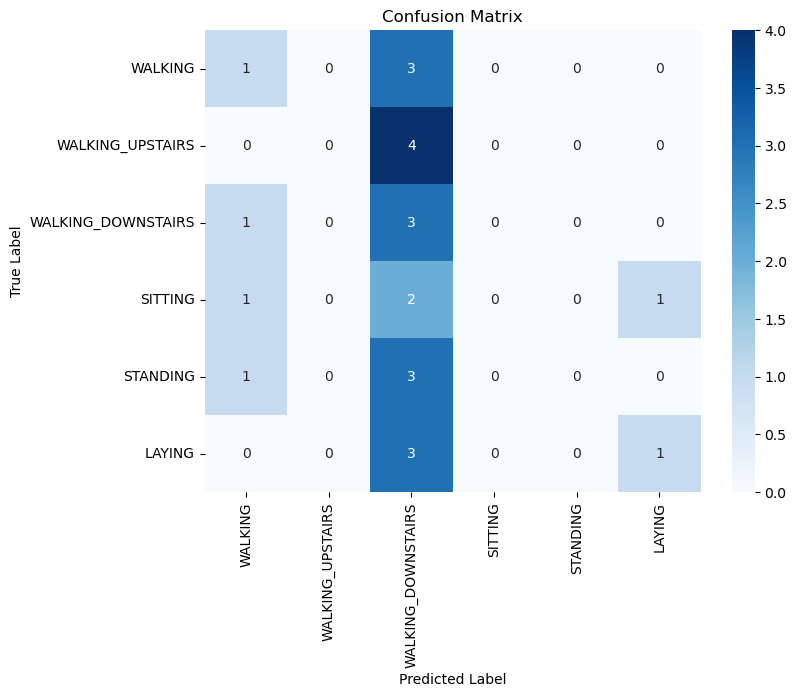

In [7]:
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Function to make API calls with retry logic for rate limit errors
def make_api_call(prompt):
    while True:
        try:
            response = llm.invoke(prompt)
            return response
        except Exception as e:
            print(f"Rate limit error: {e}. Retrying in 10 seconds...")
            time.sleep(10)

# Set up Groq API credentials and model
Groq_Token = "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"
model_name = "llama3.1-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

# Select even samples for few-shot learning examples
samples_per_activity = 3
few_shot_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_train):
    if activity_count[label] < samples_per_activity:
        few_shot_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Create few-shot examples
few_shot_examples = [
    {"input": X_train_pca_20[i].tolist(), "label": y_train[i]} for i in few_shot_indices
]

# Function to create a few-shot learning prompt
def create_few_shot_prompt(examples, query_input):
    description = '''
        You are a highly trained human activity classification model.
        Each input is a vector containing numerical values that represent transformed features.
        The data consists of 20 principal components extracted from the Human Activity Recognition dataset.
        Your task is to classify the input vector into one of the following categories:
        - 1: WALKING
        - 2: WALKING_UPSTAIRS
        - 3: WALKING_DOWNSTAIRS
        - 4: SITTING 
        - 5: STANDING
        - 6: LAYING

        Here are a few examples:\n
    '''
    prompt = description
    for ex in examples:
        example_input = ",".join(map(str, ex['input']))
        prompt += f"Input: [{example_input}]\nLabel: {ex['label']}\n\n" 
        
    query_input_str = ",".join(map(str, query_input))
    prompt += f"Now, classify the following input vector and return ONLY the number.\nInput: [{query_input_str}]\nLabel: "
    # print(len(description))
    # print(len(prompt))
    return prompt

# Select 3 samples from each activity for testing
samples_per_activity = 4
selected_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Store predictions and true labels
predictions = []
true_labels = []

# Test the selected cases
for idx in selected_indices:
    query_input = X_test_pca_20[idx].tolist()
    true_label = y_test[idx]
    prompt = create_few_shot_prompt(few_shot_examples, query_input)
    
    # Make the API call and store the prediction
    answer = make_api_call(prompt)
    predicted_label = int(answer.content.strip())
    predictions.append(predicted_label)
    true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
    print(f"Predicted label: {predicted_label}")
    print(f"True label: {true_label}")
    print("-" * 50)

# Calculate and print accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], 
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Test Case 1 (WALKING):
Predicted label: 3
True label: 1
--------------------------------------------------
Test Case 2 (WALKING_UPSTAIRS):
Predicted label: 3
True label: 2
--------------------------------------------------
Test Case 3 (WALKING_DOWNSTAIRS):
Predicted label: 3
True label: 3
--------------------------------------------------
Test Case 4 (SITTING):
Predicted label: 6
True label: 4
--------------------------------------------------
Test Case 5 (STANDING):
Predicted label: 1
True label: 5
--------------------------------------------------
Test Case 6 (LAYING):
Predicted label: 3
True label: 6
--------------------------------------------------
Test Case 7 (WALKING):
Predicted label: 3
True label: 1
--------------------------------------------------
Test Case 8 (WALKING_UPSTAIRS):
Predicted label: 3
True label: 2
--------------------------------------------------
Test Case 9 (WALKING_DOWNSTAIRS):
Predicted label: 1
True label: 3
------------------------------------------------

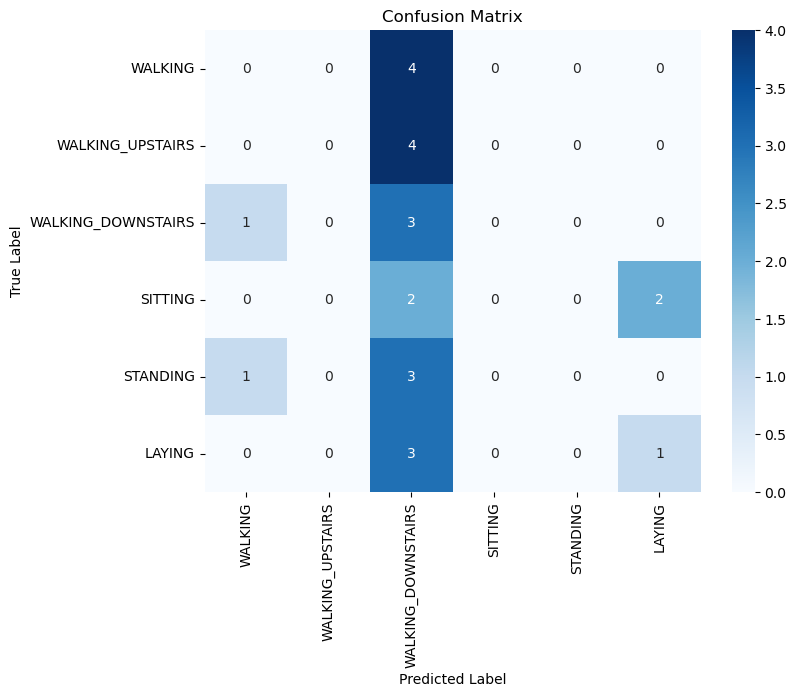

In [8]:
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Function to make API calls with retry logic for rate limit errors
def make_api_call(prompt):
    while True:
        try:
            response = llm.invoke(prompt)
            return response
        except Exception as e:
            print(f"Rate limit error: {e}. Retrying in 10 seconds...")
            time.sleep(10)

# Set up Groq API credentials and model
Groq_Token = "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"
model_name = "llama3.1-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

# Select even samples for few-shot learning examples
samples_per_activity = 3
few_shot_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_train):
    if activity_count[label] < samples_per_activity:
        few_shot_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Create few-shot examples
few_shot_examples = [
    {"input": X_train_pca_20[i].tolist(), "label": y_train[i]} for i in few_shot_indices
]

# Function to create a few-shot learning prompt
def create_few_shot_prompt(examples, query_input):
    description = '''
        You are a highly trained human activity classification model.
        Each input is a vector containing numerical values that represent transformed features.
        The data consists of 20 principal components extracted from the Human Activity Recognition dataset.
        Your task is to classify the input vector into one of the following categories:
        - 1: WALKING
        - 2: WALKING_UPSTAIRS
        - 3: WALKING_DOWNSTAIRS
        - 4: SITTING 
        - 5: STANDING
        - 6: LAYING

        Here are a few examples:\n
    '''
    prompt = description
    for ex in examples:
        example_input = ",".join(map(str, ex['input']))
        prompt += f"Input: [{example_input}]\nLabel: {ex['label']}\n\n" 
        
    query_input_str = ",".join(map(str, query_input))
    prompt += f"Now, classify the following input vector and return ONLY the number.\nInput: [{query_input_str}]\nLabel: "
    # print(len(description))
    # print(len(prompt))
    return prompt

# Select 3 samples from each activity for testing
samples_per_activity = 4
selected_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Store predictions and true labels
predictions = []
true_labels = []

# Test the selected cases
for idx in selected_indices:
    query_input = X_test_pca_20[idx].tolist()
    true_label = y_test[idx]
    prompt = create_few_shot_prompt(few_shot_examples, query_input)
    
    # Make the API call and store the prediction
    answer = make_api_call(prompt)
    predicted_label = int(answer.content.strip())
    predictions.append(predicted_label)
    true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
    print(f"Predicted label: {predicted_label}")
    print(f"True label: {true_label}")
    print("-" * 50)

# Calculate and print accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], 
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

TypeError: Object of type int32 is not JSON serializable